In [1]:
# Imports
import os
import sys
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Connect project paths
project_root = os.path.abspath("..")
src_path = os.path.join(project_root, "src")
experiments_root = os.path.join(project_root, "experiments")
data_root = os.path.join(project_root, "data", "SICAPv2")

# Add src to path
if src_path not in sys.path:
    sys.path.append(src_path)

from attention_unet import AttentionUNet
from dataset import build_dataset_from_partition
from metrics import aggregate_metrics

# print("Project root:", project_root)
# print("Experiments folder:", experiments_root)
# print("Data root:", data_root)

In [3]:
# Lets save these images as well

save_dir = os.path.join(project_root, "report", "figures", "analysis_figures")
os.makedirs(save_dir, exist_ok=True)


dice_iou_path = os.path.join(save_dir, "second_dice_iou.png")
train_val_path = os.path.join(save_dir, "second_train_val_curves.png")
dice_macro_path = os.path.join(save_dir, "second_dice_macro.png")



In [4]:
# Lets get all the Metrics from the Folds
folds = ["Val1", "Val2", "Val3", "Val4"]

metrics_list = []

for fold in folds:
    metrics_path = os.path.join(experiments_root, fold, "val_metrics.json")
    if not os.path.exists(metrics_path):
        print(f"Missing metrics for {fold}")
        continue
    
    with open(metrics_path, "r") as f:
        m = json.load(f)
        m["fold"] = fold
        metrics_list.append(m)

metrics_df = pd.DataFrame(metrics_list)
metrics_df = metrics_df.set_index("fold")

metrics_df

,pixel_accuracy,dice_per_class,dice_macro,iou_per_class,iou_macro,precision,recall,f1,f1_macro
fold,,,,,,,,,
Val1,0.996882,0.456485,0.456485,0.456096,0.456096,0.999221,0.456876,0.456490,0.456490
Val2,0.998008,0.498712,0.498712,0.498463,0.498463,0.999502,0.498961,0.498717,0.498717
Val3,0.997589,0.519636,0.519637,0.519336,0.519336,0.999397,0.519939,0.519641,0.519641
Val4,0.998035,0.618669,0.618669,0.618424,0.618424,0.999509,0.618915,0.618673,0.618673


In [5]:
# Lets save this as our table
save_dir = os.path.join(project_root, "report", "tables")
os.makedirs(save_dir, exist_ok=True)

csv_path = os.path.join(save_dir, "cv_metrics_2.csv")
metrics_df.to_csv(csv_path)

print("Saved CV metrics to:", csv_path)

Saved CV metrics to: /Users/rkakooza/Desktop/sicapv2-gleason-segmentation/report/tables/cv_metrics_2.csv


Plot for Dice and IoU

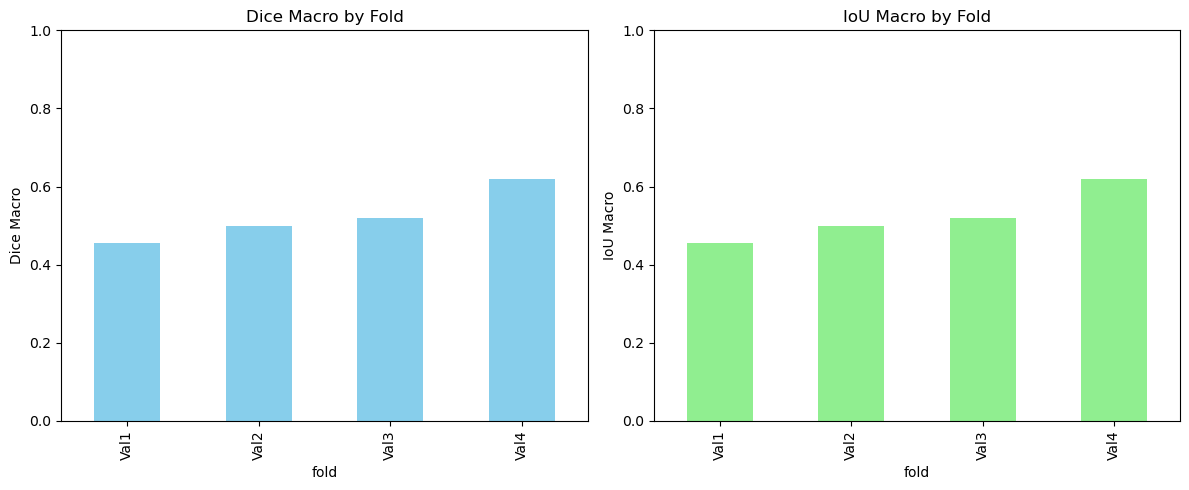

In [6]:
# Plot to see what they look like
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
metrics_df["dice_macro"].plot(kind="bar", color="skyblue")
plt.title("Dice Macro by Fold")
plt.ylabel("Dice Macro")
plt.ylim(0, 1)

plt.subplot(1,2,2)
metrics_df["iou_macro"].plot(kind="bar", color="lightgreen")
plt.title("IoU Macro by Fold")
plt.ylabel("IoU Macro")
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig(dice_iou_path, dpi=200, bbox_inches='tight')
plt.show()

Plot for training vs validation loss

In [7]:
# load the histories
histories = {}

for fold in folds:
    history_path = os.path.join(experiments_root, fold, "history.json")
    if not os.path.exists(history_path):
        print(f"Missing history for {fold}")
        continue
    
    with open(history_path, "r") as f:
        h = json.load(f)
        histories[fold] = h

histories.keys()

dict_keys(['Val1', 'Val2', 'Val3', 'Val4'])

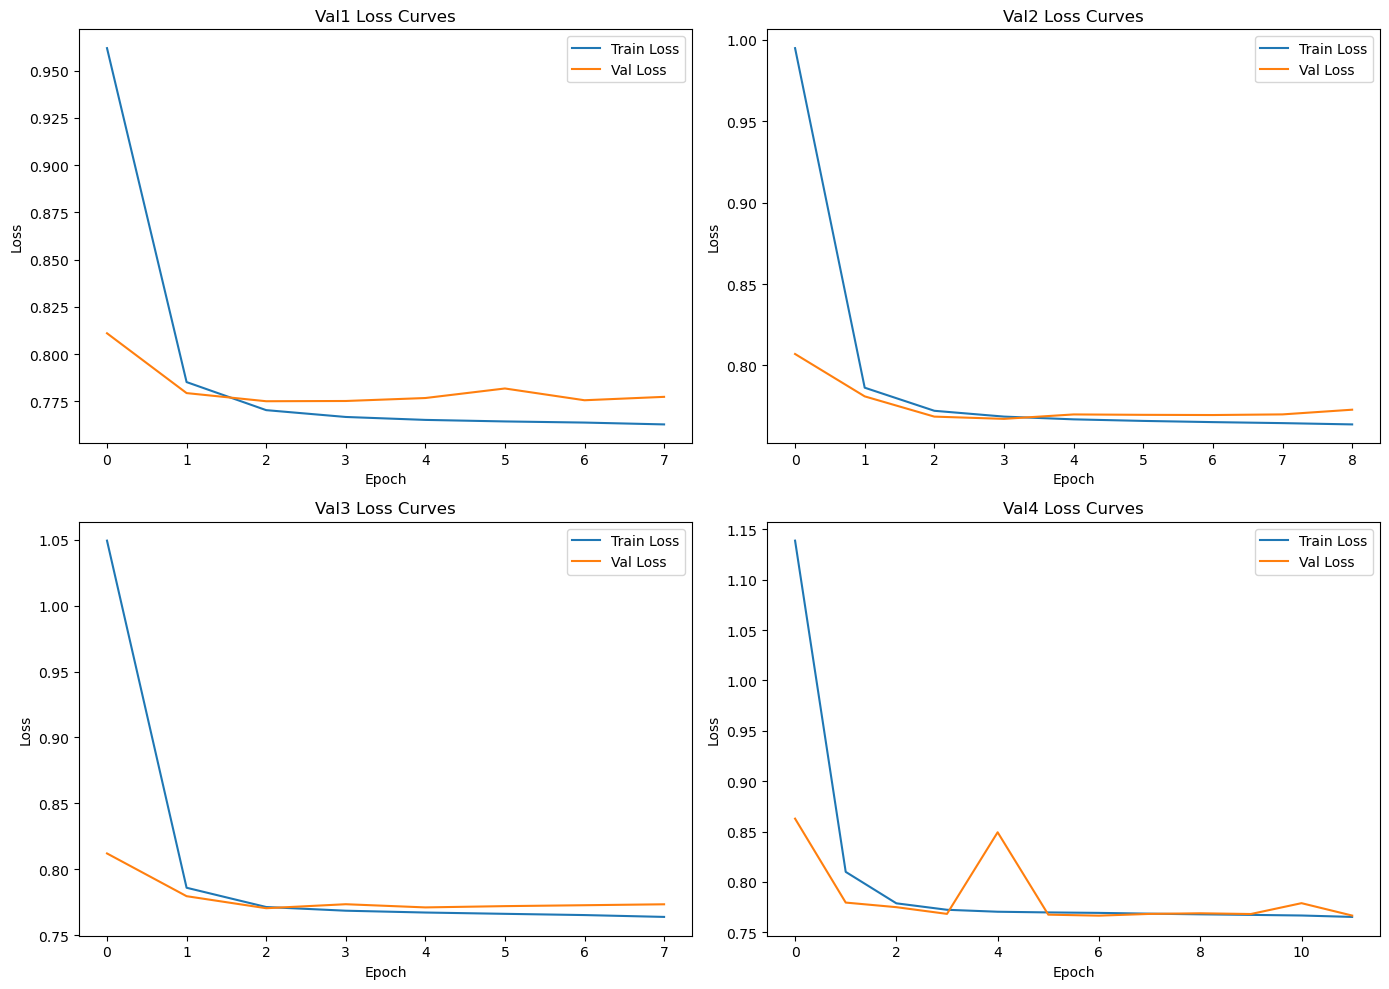

In [8]:
# Plot
plt.figure(figsize=(14,10))

for i, fold in enumerate(folds):
    if fold not in histories: 
        continue
    
    h = histories[fold]
    train_loss = h["train_loss"]
    val_loss   = h["val_loss"]
    
    plt.subplot(2, 2, i+1)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Val Loss")
    plt.title(f"{fold} Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

plt.tight_layout()
plt.savefig(train_val_path, dpi=200, bbox_inches='tight')
plt.show()

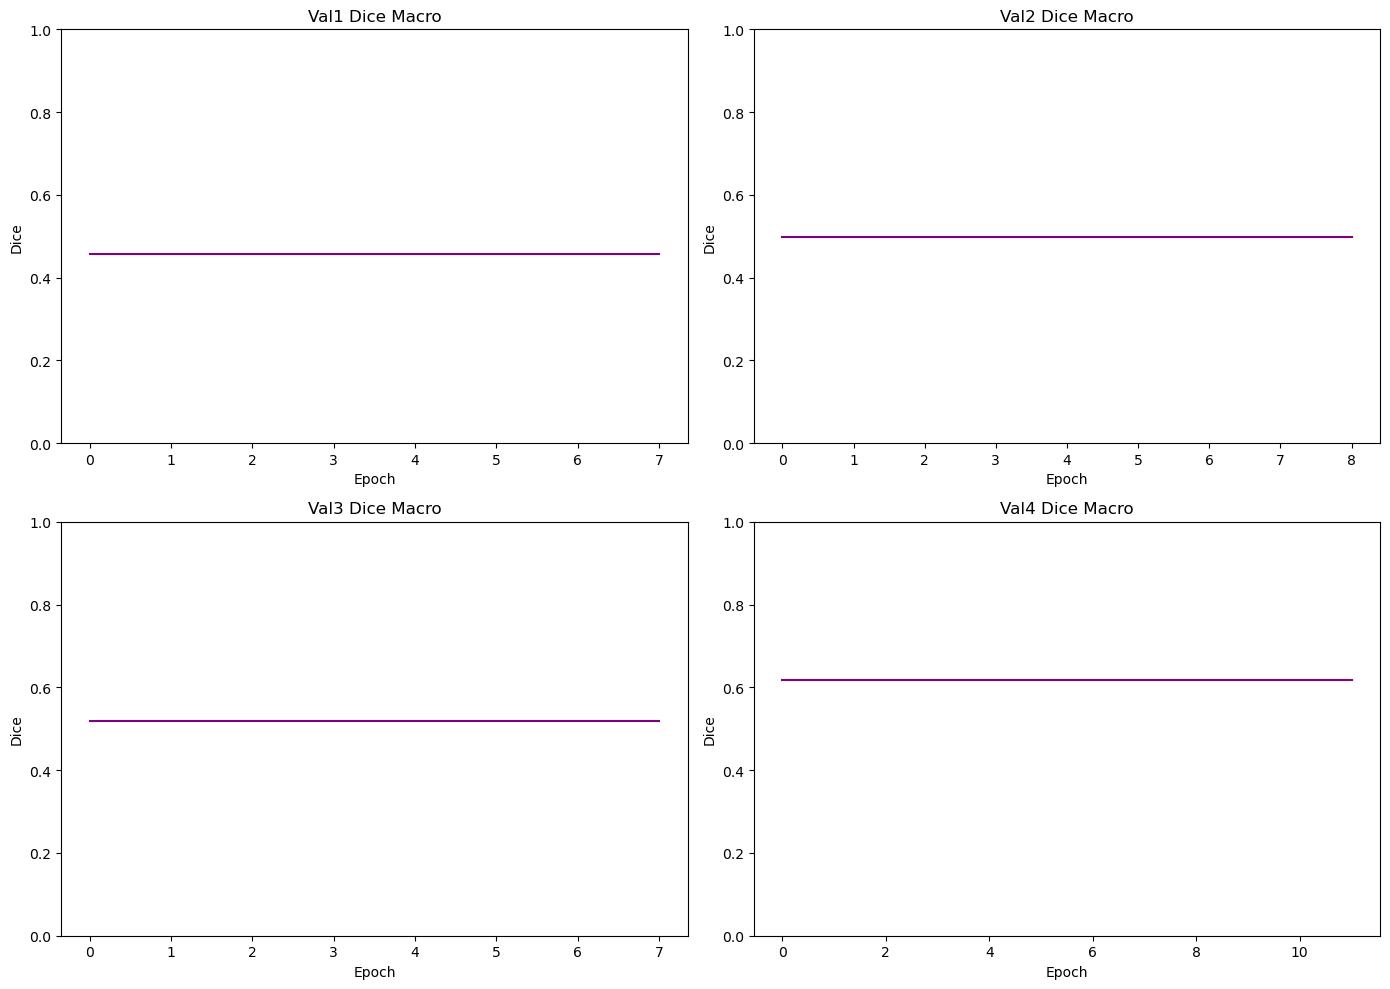

In [9]:
# Validation Dice Curves
plt.figure(figsize=(14,10))

for i, fold in enumerate(folds):
    if fold not in histories:
        continue
    
    h = histories[fold]
    dice = h["val_dice_macro"]
    
    plt.subplot(2, 2, i+1)
    plt.plot(dice, color="purple")
    plt.title(f"{fold} Dice Macro")
    plt.xlabel("Epoch")
    plt.ylabel("Dice")
    plt.ylim(0, 1)

plt.tight_layout()
plt.savefig(dice_macro_path, dpi=200, bbox_inches='tight')
plt.show()

In [10]:
# best epoch for each fold
for fold in folds:
    if fold not in histories:
        continue
    dice = histories[fold]["val_dice_macro"]
    best_epoch = int(np.argmax(dice) + 1)
    best_score = max(dice)
    print(f"{fold}: best epoch = {best_epoch}, best dice = {best_score:.4f}")

Val1: best epoch = 1, best dice = 0.4565
Val2: best epoch = 1, best dice = 0.4987
Val3: best epoch = 1, best dice = 0.5196
Val4: best epoch = 1, best dice = 0.6187


These results will help us decide how to plan for early stopping, LR scheduling and figure out optimal number of epochs to run for final training.

Interpretation of Curves from first run

Train Loss & Validation Loss for all Folds:
* Train Loss decreases steadily every epoch
* Validation loss decreases early but then:
 * Val1: it plateaus and gets worse
 * Val2 & Val3: Small falctuations then small increase up
 * Val4: stable with minimal increase

So model is learning but around epochs 3 to 5, thats where we hit peak validation DICE.

Then from 5 to 7 training loss keeps improving but validation does not which is basically where we start to see OVERFITTING.